# Language detection of transliterated text

### The problem
Below is a text transliterated in English:

| "aaj ka mausam achchha hai" | "The weather is good today" |
| --- | --- |
| (transliterated text) | (translated text) |

One might be curious about what language is this transliterated text actually in (unless one knows that language already). Happens to me quite often, when I'm reading Youtube or Facebook or other social media threads.

Well, the above text is in Hindi:

| "aaj ka mausam achchha hai" | "आज का मौसम अच्छा है" |
| --- | --- |
| (transliterated text) | (original script) |

Since computer and phone keyboards are generally in English, it is often convenient for non-roman language speakers to transliterate their texts to English while typing than to use the original script (writing system) of their language. Since the transliterated text does not have the information about its original language, it becomes hard for others (who do not speak that language) to even decipher the language and further understand the meaning of the text.

It would be convenient if machines could fill this gap by telling us the language of those transliterated texts, which we very often encounter in social media threads etc., so that we don't have to ask other people if they can identify the language of a transliterated text.

### Scope of the project

In this project, I therefore attempt to address this problem by designing an NLP model which can detect the language of a transliterated text. Due to lack of time at the moment, I confine the scope of this project to just classify texts transliterated from Korean and Bangla (Bengali) languages. 

Although not important, but the reason for choosing these two non-roman languages in particular for the project is because:  
* Bangla is my mother tongue so it would be fun to teach the machine my language. Bangla (or Bengali) is spoken mostly in the state of West Bengal in India and in Bangladesh. 
* Korean pop songs are popular lately, so considering their international reach, I thought, Korean transliteration might be relevant to people.
* I shall be including other non-roman languages in the future.

### Solution approach

We can often identify a language being spoken, if we have prior experience of hearing that language, even if we may not understand the language at all. Every language has some characteristic sounds patterns. These patterns can be used to identify a language even without understanding them. So, like speech if we could pronounced transliterated texts correctly (ie in their native langauge pronounciation), we might be able to identify the language.

Automatic Speech Recognition (ASR) systems are pretty decent in identifying language from speech audio inputs. ASRs use spectrograms (shown below) to learn the features including the language of a speech input.

<img src="https://www.researchgate.net/profile/Phillip_Lobel/publication/267827408/figure/fig2/AS:295457826852866@1447454043380/Spectrograms-and-Oscillograms-This-is-an-oscillogram-and-spectrogram-of-the-boatwhistle.png"  width="400">

[Image source: Kovitvongsa, Kathryn & Lobel, Phillip. (2019). Convenient Fish Acoustic Data Collection in the Digital Age.]

In spectrograms, audio files are chopped into thin time slices (in the abscissa), where for each time slice all the frequencies present are listed (in the ordinate) with their corresponding intensities (heat map) using Fourier transform. The frequencies tell us about the nature of the source that produced that sound, e.g., you can identify musical instruments by the pattern of their overtones (multiples of fundamental frequency).

This also means that if we look at spectrograms of human speech audio files, the frequencies in a particular time slice should represent which part of our buccal cavity contributed in production of sound in that time slice or window. In other words, the time slices in a spectrogram try to capture the elementary bits of characteristic sound patterns (by encoding the information about which part of buccal cavity produced them) of a speech which ASRs can use in trying to indetify the language of the speech (there are other ASR applications as well than language identification).

If we could split our transliterated words into elementary fragments, that uniquely encode the source (such as the region in buccal cavity) which produces them, a string of those word fragments would be analogous to spectrograms for audio speech. We can then use those word fragment strings as inputs to an NLP model to identify the language of the transliterated text.

Fortunately, when a text is transliterated from one langauge to other, it is generally spelled out phonetically (even if the original language is not strictly phonetic). So, if we were to phonetically pronounce the transliterated words, we might be quite closer to its actual pronounciation.

To get the phonetic pronounciation, we assumed that the texts were transliterated from some unknown language to Italian, a strictly phonetic language which also uses the Latin script as English. We then divide the transliterated words into syllables according to the  Italian language, ie phonetically. We used those (phonetic) syllables as inputs to our NLP model.

# Data scraping

Song lyrics website often transliterate songs in English (perhaps for international audiences). So, for Korean and Bangla (Bengali) sentences transliterated in English, the song lyrics on the following lyrics websites were scraped:
 - bangla lyrics: http://www.lyricsbangla.com/
 - korean lyrics: https://romanization.wordpress.com/

In [1]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re

Since the objects in Bengali (referred as Bangla henceforth) and Korean texts might be different created two separate functions to fetch respective text. The different functions are just for cleanliness purpose.

### Functions for scraping Korean transliterated texts

In [3]:
def fetch_korean(fname):
    #some browsing revealed there are 1087 pages (@29th July, 2019) indexed 0 through 1086 with links to lyrics
    #extracting the song links from each of these pages
    npages = 1087
    lyricsbag = open(fname, 'w')
    count = 0
    for pg in range(npages):
        soup = BeautifulSoup(urlopen("https://romanization.wordpress.com/page/%i"%pg), 'html.parser')
        links = soup.find_all('a')
        pageurls = [_.get('href') for _ in links if (_.text == 'Continue reading →')]
        for url in pageurls:
            b = koreanLyrics(url)
            [lyricsbag.write(_+"\n") for _ in b]
            count += 1
            print(count)
    
    return


In [4]:
def koreanLyrics(url):
    s = BeautifulSoup(urlopen(url), 'html.parser')
    lblob = [_.text for _ in s.find_all('p')]
    lyrics = []
    pendown = False
    for _ in lblob:
        if pendown:
            if (_ == "//"):
                pendown = False
                break
            else:
                lyrics += _.split("\n")
        else:
            if "to see the lyrics" in _:
                pendown = True
    return lyrics

### Functions for scraping Bangla transliterated texts

In [5]:
def fetch_bangla(fname):
    #url = "http://www.lyricsbangla.com/?sec=listing&lyricid=4140"
    url = "file:///home/sourav/MLProjects/transliterate/Lyrics%20Search%20»%20LyricsBangla.com.html" 
    #TODO replace the static page with dynamic link smh
    #"http://www.lyricsbangla.com/index.php?sec=search"
    html = urlopen(url)

    soup = BeautifulSoup(html, 'html.parser')
    b = soup.find('table')
    urltable = b.find_all('td')
    
    #extracting songs from links in www.lyricsbangla.com index page
    lyricsurllist = []
    lyricsbag = open(fname, 'w')
    count = 0
    for u in urltable:
        if (u.find('a') != None):
            songlink = u.a.get('href')
            if ("artist" not in songlink):
                b = banglaLyrics(songlink)
                [lyricsbag.write(_+"\n") for _ in b]
                count += 1
                print(count)
        
    return
    

Bangla lyrics often have chords, so here is a list of chords to clean the text scraped from: https://www.pianochord.org/ and saved in "chords.txt"

In [6]:
##(source: https://www.pianochord.org/)
def get_musicalchords():
    chords_ = []
    f = open("chords.txt", 'r')
    lines = f.readlines()
    for l in lines:
        chords_ += l.strip().split()

    return chords_

In [7]:
def banglaLyrics(url):
    spchar = re.compile('[@_!#$%^&*()<>?/\|}{~:]')


    s = BeautifulSoup(urlopen(url), 'html.parser')
    lblob = s.find('p', id='tabs-1')
    lyrics = []
    chord_ = get_musicalchords()
    for line in lblob:
        if (line.string != None):
            l = str(line)
            if any(chord in l for chord in chords_):
                continue
            elif (spchar.search(l)!=None):
                continue
            else:
                l = l.strip()
                if (l): lyrics.append(l)
    return lyrics

The following cell scrapes Bangla and Korean lyrics respectively using the functions defined above.

In [145]:
banglacorpus = "banglacorpus.txt"
fetch_bangla(banglacorpus)


koreancorpus = "koreancorpus.txt"
fetch_korean(koreancorpus)


# Data Cleaning

"cleanedkoreancorpus.txt" and "cleanedbanglacorpus.txt" are the cleaned corpuses for Korean and Bangla transliterated text used for the analysis

<div style="text-align: right"> "Cleaning is messy!!" ~Anonymous </div>

# Data Visualization for encoding

While transliteration, words are spelled phonetically. So, if one spells the transliterated word phonetically, one might actually get quite close to the actual pronounciation in its native language.
If the transliterated words are, therefore, split into phonetic syllables, a list of those phonetic syllables could represent the pronounciation of that word and thus information about its native language. These phonetic syllables are quite analogous to phoneme sequences used in ASR (Automatic Speech Recognition).

Since English is not a phonetic language, its syllables are not phonetic. However, with we try to split the word using a phonetic language, like Italian, then the syllables would indeed be phonetic.

I use a python package - 'pyphen' (https://pyphen.org) for such syllable splitting. This package provides an option to choose the language in which the user wants to split the word. As discussed above, I used Italian, a phonetic language, to split the word into syllables, so that I get phonetic syllables.

Installing pyphen:

In [1]:
# Install pyphen in the current Jupyter kernel
import sys
!{sys.executable} -m pip install pyphen

  Using cached https://files.pythonhosted.org/packages/15/82/08a3629dce8d1f3d91db843bb36d4d7db6b6269d5067259613a0d5c8a9db/Pyphen-0.9.5-py2.py3-none-any.whl


The function below splits the words phonetically (as in italian) into list of syllables to be used as input features for langauge detection:

In [9]:
def wordbagmaker(corpusfilename, label):
   f = open(corpusfilename, 'r')
   lines = f.readlines()

   import random
   import pyphen
   worddict = []
   dic = pyphen.Pyphen(lang='it_IT')
   for l in lines:
       words = l.split()
       if (len(words) < 2): continue #only words present in sentences used, not single word sentences
       for w in words:
          if (len(w) > 1) and w.isalpha(): #words with digits not used and single letter words not used
              worddict.append(dic.inserted(w) + " : " + label)

   random.shuffle(worddict)   #shuffle the list
   return worddict

The words split into phonetic syllables are stored in koreanwordbag.txt and banglawordbag.txt for Korean and Bangla resp. and used to train and test the langauge detection model.

In [10]:
foK = open("koreanwordbag.txt", 'w')
[foK.write(wK+"\n") for wK in wordbagmaker("cleanedkoreancorpus.txt", "K")]
foK.close()
foB = open("banglawordbag.txt", 'w')
[foB.write(wB+"\n") for wB in wordbagmaker("cleanedbanglacorpus.txt", "B")]
foB.close()

In [1]:
fkor = open("koreanwordbag.txt", 'r')
fban = open("banglawordbag.txt", 'r')
datakor = fkor.readlines()
databan = fban.readlines()

A quick feature visualization to see if simple features, like syllable count per word,have any discriminating power.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
syllables_per_wordKOR = []
letters_per_syllableKOR = []
for dK in datakor:
    w = dK.split(" : ")[0].split("-")
    syllables_per_wordKOR.append(len(w))
    [letters_per_syllableKOR.append(len(_)) for _ in w]

syllables_per_wordBAN = []
letters_per_syllableBAN = []
for dB in databan:
    w = dB.split(" : ")[0].split("-")
    syllables_per_wordBAN.append(len(w))
    [letters_per_syllableBAN.append(len(_)) for _ in w]

syllables_per_word = np.concatenate((syllables_per_wordKOR,syllables_per_wordBAN), axis=0)
letters_per_syllable = np.concatenate((letters_per_syllableKOR, letters_per_syllableBAN), axis=0)

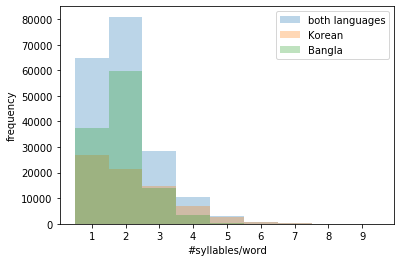

In [4]:
binsSPW = [_ - 0.5 for _ in range(1,11)]
plt.xticks(range(1,11))
plt.hist(syllables_per_word, binsSPW, alpha=0.3, label='both languages')
plt.hist(syllables_per_wordKOR, binsSPW, alpha=0.3, label='Korean') 
plt.hist(syllables_per_wordBAN, binsSPW, alpha=0.3, label='Bangla')

plt.xlabel('#syllables/word')
plt.ylabel('frequency')
plt.legend(loc='best')
plt.show()

Bangla words mostly have 2 syllables, Korean words can have upto 5 syllables in a word. A 10 syllable vector should be enough to encode a word from either language.

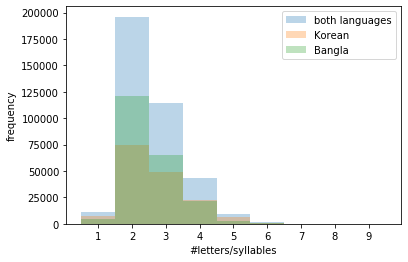

In [5]:
binsLPS = [_ - 0.5 for _ in range(1,11)]
plt.xticks(range(1,11))
plt.hist(letters_per_syllable, binsLPS, alpha=0.3, label='both languages')
plt.hist(letters_per_syllableKOR, binsLPS, alpha=0.3, label='Korean') 
plt.hist(letters_per_syllableBAN, binsLPS, alpha=0.3, label='Bangla')

plt.xlabel('#letters/syllables')
plt.ylabel('frequency')
plt.legend(loc='best')
plt.show()

Most phonetic syllables have around 2 letters. Not a significant disciminator. Would therefore be fair to disregard the syllable length and just integer encode the syllables in both the corpuses.

# Training data

Using 50,000 (10,000) Bangla and Korean words each randomly from the corpuses for training (testing).

In [6]:
import random
Ntrain = 50000
Ntest  = 10000
random.shuffle(datakor) #korean
random.shuffle(databan) #bangla
TrainingVal_data = datakor[:Ntrain] + databan[:Ntrain] 
Testing_data = datakor[Ntrain:Ntrain+Ntest] + databan[Ntrain:Ntrain+Ntest]
random.shuffle(TrainingVal_data)
random.shuffle(Testing_data)

# Word and label encoding

In [7]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.
/home/sourav/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sourav/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sourav/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sourav/.local/lib/python3.6/site-packages/tensorflow/python

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM

In [9]:
#training data
wordvec = []
labelvec = [] 
for td in TrainingVal_data:
    wvec = []
    tw, tl = td.split(" : ")
    tw = tw.replace("-", " ")
    lvec = [1, 0] if tl.strip() == "B" else [0,1]                #One hot encoding: [1,0] : Bangla, [0,1] : Korean
    wordvec.append(tw)
    labelvec.append(lvec)
labelvec = np.array(labelvec)
print(wordvec[:3])
print(labelvec[:3])


#testing data
wordvec_test = []
labelvec_test = [] 
for td in Testing_data:
    wvec = []
    tw, tl = td.split(" : ")
    tw = tw.replace("-", " ")
    lvec = [1, 0] if tl.strip() == "B" else [0,1]                #One hot encoding: [1,0] : Bangla, [0,1] : Korean
    wordvec_test.append(tw)
    labelvec_test.append(lvec)
labelvec_test = np.array(labelvec_test)


['ji wo ji ket', 'gal la do', 'hay re']
[[0 1]
 [0 1]
 [1 0]]


integer encode the phonetic syllables:

In [10]:
vocab_size = 200000

#training data
print(wordvec[:5])
encoded_docs = [one_hot(d, vocab_size) for d in wordvec]
print(encoded_docs[:5])

#testing data
print(wordvec_test[:5])
encoded_docs_test = [one_hot(d, vocab_size) for d in wordvec_test]
print(encoded_docs_test[:5])


['ji wo ji ket', 'gal la do', 'hay re', 'ja lhae', 'ha ta ta ta tat']
[[96377, 137203, 96377, 162211], [38693, 33129, 37160], [38823, 2238], [92218, 144604], [126174, 185772, 185772, 185772, 111861]]
['back', 'ke mon', 'cho ke', 'cho kher', 'aa sh be']
[[77093], [10649, 195876], [36948, 10649], [36948, 27349], [15221, 141540, 102885]]


pad words to a max length of 10 syllables:

In [11]:
max_length = 10

#training data
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

#testing data
padded_docs_test = pad_sequences(encoded_docs_test, maxlen=max_length, padding='post')

[[ 96377 137203  96377 ...      0      0      0]
 [ 38693  33129  37160 ...      0      0      0]
 [ 38823   2238      0 ...      0      0      0]
 ...
 [ 82406      0      0 ...      0      0      0]
 [ 14922 130254 106980 ...      0      0      0]
 [ 51131  12383  89268 ...      0      0      0]]


I train an LSTM to classify Korean and Bangla words, defined below:

In [28]:
from keras.regularizers import l2

lstm_out = 5
# define the model
model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=max_length))
model.add(LSTM(lstm_out, recurrent_initializer="random_uniform", bias_initializer="zeros", dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dense(2, activation='softmax'))

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 10, 8)             1600000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 5)                 280       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 12        
Total params: 1,600,292
Trainable params: 1,600,292
Non-trainable params: 0
_________________________________________________________________
None


train the LSTM:

Early stopping the training if validation loss starts to converge (wait for 50 epochs to make sure val loss is indeed converging). 

In [34]:
from keras.callbacks import EarlyStopping
class ThresholdEarlyStopping(EarlyStopping):
    def __init__(self, monitor='val_loss', min_epochs=10,
                 threshold=0.995, increase=1.75, verbose=0, mode='auto'):

        super(ThresholdEarlyStopping, self).__init__(
            monitor=monitor,
            patience=min_epochs,
            verbose=verbose,
            mode=mode
        )

        self.threshold = threshold
        self.increase = increase

    def on_epoch_end(self, epoch, logs={}):
        if epoch < self.patience:
            current = logs.get(self.monitor)
            if current is None:
                warnings.warn('Early stopping requires %s to be available!'
                              % (self.monitor), RuntimeWarning)

            if self.monitor_op(current, self.best):
                # if current val_loss within 0.5% margin of the best(min) val_loss, 
                # add some grace to the patience to monitor if val_loss is indeed converging 
                if self.monitor_op(current, self.threshold*self.best):
                    self.patience = max(self.patience, epoch*self.increase)
                self.best = current

        else:
            if self.verbose > 0:
                print('Epoch %05d: early stopping' % (epoch))

            self.model.stop_training = True

In [29]:
# fit the model
print(labelvec[:5])
history = model.fit(padded_docs, labelvec, batch_size=2000, validation_split=0.1, epochs=500, verbose=1, callbacks=[ThresholdEarlyStopping(verbose=1, min_epochs=50)])

[[0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]]
Train on 90000 samples, validate on 10000 samples
Epoch 1/500
90000/90000 [==============================] - 3s 38us/step - loss: 0.8437 - acc: 0.5235 - val_loss: 0.8257 - val_acc: 0.5101
Epoch 2/500
90000/90000 [==============================] - 2s 20us/step - loss: 0.8107 - acc: 0.5716 - val_loss: 0.7960 - val_acc: 0.8591
Epoch 3/500
90000/90000 [==============================] - 2s 21us/step - loss: 0.7803 - acc: 0.6838 - val_loss: 0.7599 - val_acc: 0.7324
Epoch 4/500
90000/90000 [==============================] - 2s 21us/step - loss: 0.6925 - acc: 0.7834 - val_loss: 0.5677 - val_acc: 0.8844
Epoch 5/500
90000/90000 [==============================] - 2s 21us/step - loss: 0.4756 - acc: 0.8768 - val_loss: 0.3664 - val_acc: 0.9175
Epoch 6/500
90000/90000 [==============================] - 2s 21us/step - loss: 0.3791 - acc: 0.9178 - val_loss: 0.3292 - val_acc: 0.9301
Epoch 7/500
90000/90000 [==============================] - 2s 21us/step - loss: 0.3451

Epoch 118/500
90000/90000 [==============================] - 2s 20us/step - loss: 0.1709 - acc: 0.9425 - val_loss: 0.1828 - val_acc: 0.9337
Epoch 119/500
90000/90000 [==============================] - 2s 23us/step - loss: 0.1720 - acc: 0.9423 - val_loss: 0.1838 - val_acc: 0.9358
Epoch 120/500
90000/90000 [==============================] - 2s 21us/step - loss: 0.1724 - acc: 0.9420 - val_loss: 0.1873 - val_acc: 0.9347
Epoch 121/500
90000/90000 [==============================] - 2s 20us/step - loss: 0.1725 - acc: 0.9420 - val_loss: 0.1812 - val_acc: 0.9313
Epoch 122/500
90000/90000 [==============================] - 2s 21us/step - loss: 0.1718 - acc: 0.9428 - val_loss: 0.1808 - val_acc: 0.9352
Epoch 123/500
90000/90000 [==============================] - 2s 22us/step - loss: 0.1708 - acc: 0.9421 - val_loss: 0.1806 - val_acc: 0.9305
Epoch 124/500
90000/90000 [==============================] - 2s 20us/step - loss: 0.1709 - acc: 0.9418 - val_loss: 0.1803 - val_acc: 0.9321
Epoch 125/500
90000/

check for overfitting by comparing the validation loss with training loss:

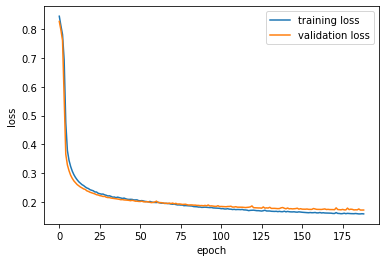

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss', 'validation loss'], loc='best')
plt.show()

The model is trained.

evaluating the LSTM language classifier with testing data (with default decision boundary = 0.5):

In [31]:
# evaluate the model
loss, accuracy = model.evaluate(padded_docs_test, labelvec_test, verbose=0)
print('Accuracy: %f %%' % (accuracy*100))

Accuracy: 93.265000 %


Optimizing the decision boundary of the LSTM classifier for best accuracy using ROC curve:

In [48]:
labelvec_pred[:5], labelvec_test[:5, 0]

(array([0.00250873, 0.99749124, 0.98861396, 0.01138606, 0.9624189 ],
       dtype=float32), array([0, 1, 1, 1, 1]))

In [61]:
from sklearn.metrics import roc_curve, auc
labelvec_pred = model.predict(padded_docs_test)
fpr, tpr, cut = roc_curve(labelvec_test.ravel(), labelvec_pred.ravel())
AUC = auc(fpr, tpr)

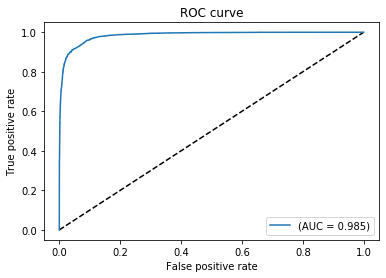

In [58]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='(AUC = {:.3f})'.format(AUC))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Closest point to (0,1) on the ROC above will have the optimal threshold (which reduces error conributed from both type I and II errors):

In [77]:
tprDist = np.square(tpr-1)
fprDist = np.square(fpr)
DistFromPerfectEff = tprDist + fprDist

Optimum_cut = cut[DistFromPerfectEff.argmin()]
Optimum_cut

0.49792165

Meh! Optimal threshold close enough to 0.5 (default cut for accuracy).

## Results
   
   The LSTM classifier using phonetic syllables as input features is able to give an optimum accuracy of ~93 % with AUC = 0.985.

### Next steps:
 - Perform k-fold cross-validation to better estimate classifier's performance
 - Store the model (in h5 format) and then create a small interface for users to run (test) the model
 - Should test vanilla RNN too since the input string of phonetic syllables are not too long
 - Improve cleaning to get rid of non-lexical vocables in the corpus to train a better discriminator
 - Try to find other sources (than song lyrics) for Korean and Bangla transliterated texts
 - Think of a better way to reduce even further English words that are contaminating the corpuses
 - Add other non-roman langauges
